# Dual Recursive Feedback Demo

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
import torch
import yaml
from PIL import Image
import matplotlib.pyplot as plt
from argparse import Namespace
from datetime import datetime
from time import time

# Diffusers and library
from diffusers import DDIMScheduler, StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image
from os import makedirs, path

from drf.pipelines.pipeline_sdxl import DRFPipeline
from drf.utils.sdxl import *

/home/zonnyg1/anaconda3/envs/ctrlx/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Parameters

In [7]:
# terminal parameters setting
args = Namespace(
    # structure image & appearance image root
    structure_image='dataset/structure/person_mesh.jpg', 
    appearance_image='dataset/appearance/tiger.jpg', 
    
    # prompts
    prompt="a photo of a tiger standing on the snow field",
    structure_prompt="a mesh of a standing human",
    appearance_prompt="a photo of a tiger walking on the snow field",

    ######################## Default Parameters ########################
    positive_prompt="high quality",
    negative_prompt="ugly, blurry, dark, low res, unrealistic",
    guidance_scale=5.0,
    structure_guidance_scale=5.0,
    appearance_guidance_scale=5.0,
    structure_schedule=0.6,
    appearance_schedule=0.6,
    #####################################################################

    num_inference_steps=50,
    eta=1.0,
    seed=90095,

    # esolution
    width=512,
    height=512,
    
    # output folder
    output_folder="./results/demo/tiger",
    model=None,
    disable_refiner=False,
    benchmark=True
)
os.makedirs(args.output_folder, exist_ok=True)

## Load Models

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if device == "cuda" else torch.float32

# model: 512 resolution (hotshotco pretrained SDXL)
model_id_or_path = "hotshotco/SDXL-512"
refiner_id_or_path = "stabilityai/stable-diffusion-xl-refiner-1.0"

# DDIM scheduler
scheduler = DDIMScheduler.from_config(model_id_or_path, subfolder="scheduler")

# import DRFPipeline class pipeline
if args.model is None:
    pipe = DRFPipeline.from_pretrained(
        model_id_or_path, scheduler=scheduler, torch_dtype=torch_dtype, use_safetensors=True
    )
else:
    pipe = DRFPipeline.from_single_file(args.model, scheduler=scheduler, torch_dtype=torch_dtype)

refiner = None
if not args.disable_refiner:
    refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
        refiner_id_or_path, scheduler=scheduler, text_encoder_2=pipe.text_encoder_2, vae=pipe.vae,
        torch_dtype=torch_dtype, use_safetensors=True
    )

pipe = pipe.to(device)
if refiner:
    refiner = refiner.to(device)

print(f"Models loaded on: {device}")

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.01it/s]


Models loaded on: cuda


## Run Inference and Display Results

In [10]:
structure_image = load_image(args.structure_image) if args.structure_image else None
appearance_image = load_image(args.appearance_image) if args.appearance_image else None

# seed
seed_everything(args.seed)
generator = torch.Generator(device).manual_seed(args.seed)

pipe.scheduler.set_timesteps(args.num_inference_steps, device=device)
timesteps = pipe.scheduler.timesteps
control_config_str = get_control_config(args.structure_schedule, args.appearance_schedule)
config = yaml.safe_load(control_config_str)
register_control(
    model=pipe,
    timesteps=timesteps,
    control_schedule=config["control_schedule"],
    control_target=config["control_target"],
)
self_recurrence_schedule = get_self_recurrence_schedule(config["self_recurrence_schedule"], args.num_inference_steps)

start_time = time()

# pipeline
result, structure, appearance = pipe(
    prompt=args.prompt,
    structure_prompt=args.structure_prompt,
    appearance_prompt=args.appearance_prompt,
    structure_image=structure_image,
    appearance_image=appearance_image,
    generator=generator,
    num_inference_steps=args.num_inference_steps,
    negative_prompt=args.negative_prompt,
    positive_prompt=args.positive_prompt,
    height=args.height,
    width=args.width,
    guidance_scale=args.guidance_scale,
    structure_guidance_scale=args.structure_guidance_scale,
    appearance_guidance_scale=args.appearance_guidance_scale,
    eta=args.eta,
    output_type="pil",
    return_dict=False,
    control_schedule=config["control_schedule"],
    self_recurrence_schedule=self_recurrence_schedule,
)

# refiner (if use)
if refiner is not None:
    result_refiner = refiner(
        image=pipe.refiner_args["latents"],
        prompt=pipe.refiner_args["prompt"],
        negative_prompt=pipe.refiner_args["negative_prompt"],
        generator=generator,
        height=args.height,
        width=args.width,
        num_inference_steps=args.num_inference_steps,
        guidance_scale=args.guidance_scale,
    ).images[0]
else:
    result_refiner = None

end_time = time()

# save
if args.benchmark:
    print(f"Inference time: {end_time - start_time:.2f}s")
    if torch.cuda.is_available():
        peak_memory = torch.cuda.max_memory_reserved() / (1024**3)
        print(f"Peak memory usage: {peak_memory:.2f} GiB")


result[0].save(path.join(args.output_folder, f"result_{args.seed}.jpg"), quality=JPEG_QUALITY)
result_refiner.save(path.join(args.output_folder, f"refiner_{args.seed}.jpg"), quality=JPEG_QUALITY)


100%|██████████| 15/15 [00:01<00:00, 12.07it/s]


Inference time: 53.61s
Peak memory usage: 18.72 GiB


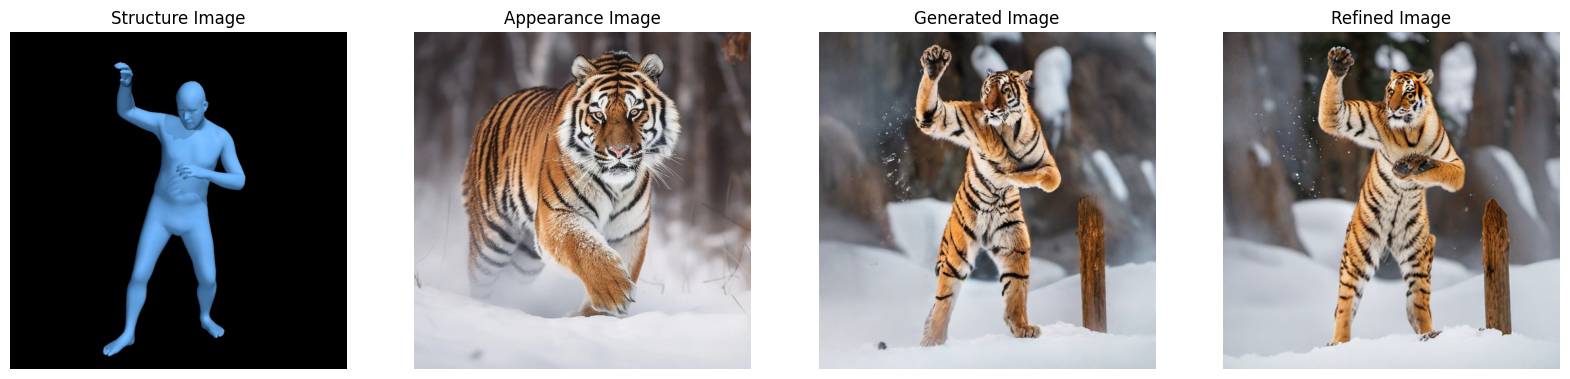

In [11]:
"""
prompt="a photo of a tiger standing on the snow field",
structure_prompt="a mesh of a standing human",
appearance_prompt="a photo of a tiger walking on the snow field",
"""

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(structure_image)
axs[0].set_title('Structure Image')
axs[0].axis('off')

axs[1].imshow(appearance_image)
axs[1].set_title('Appearance Image')
axs[1].axis('off')

axs[2].imshow(result[0])
axs[2].set_title('Generated Image')
axs[2].axis('off')

if result_refiner:
    axs[3].imshow(result_refiner)
    axs[3].set_title('Refined Image')
    axs[3].axis('off')
else:
    axs[3].set_visible(False)
    axs[3].axis('off')
plt.show()

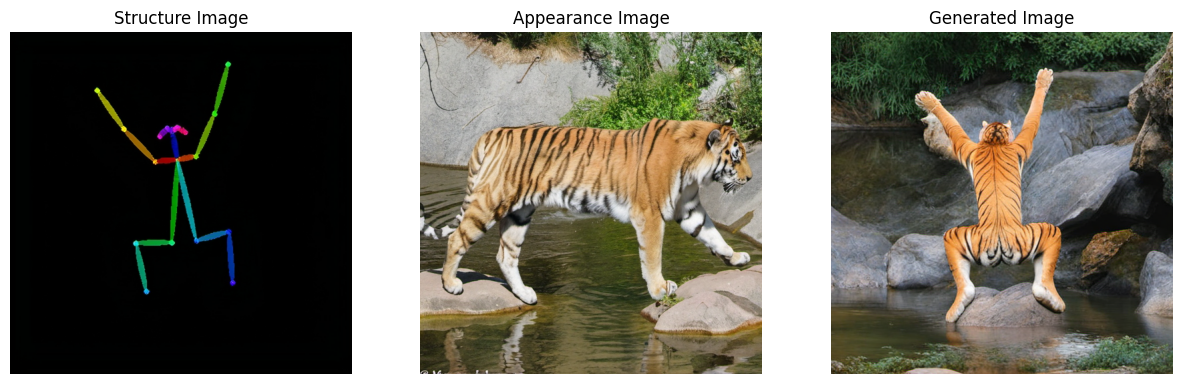

In [ ]:
"""
prompt="a photo of a tiger posing on the water in the valley",
structure_prompt="a skelton pose of a posing human",
appearance_prompt="a photo of a tiger posing on the water in the valley",
"""

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(structure_image)
axs[0].set_title('Structure Image')
axs[0].axis('off')

axs[1].imshow(appearance_image)
axs[1].set_title('Appearance Image')
axs[1].axis('off')

axs[2].imshow(result[0])
axs[2].set_title('Generated Image')
axs[2].axis('off')

plt.show()

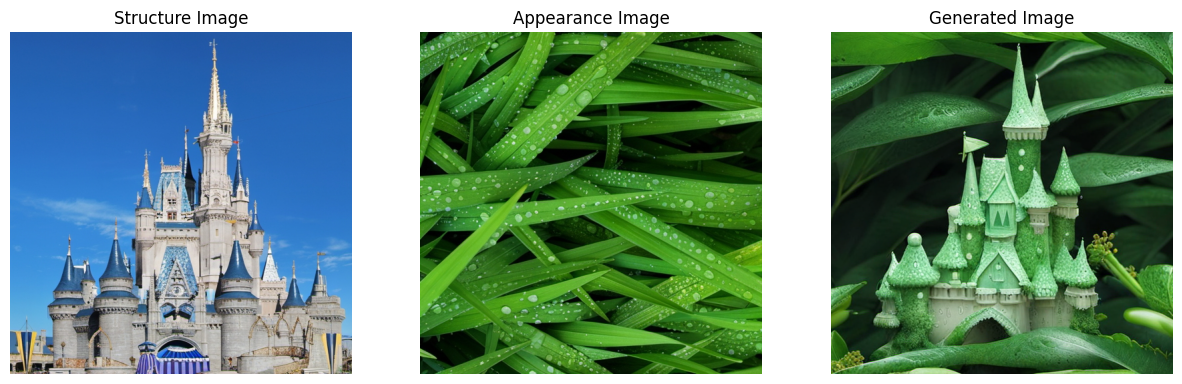

In [ ]:
"""
prompt="Disney castle made with green leaves with dew",
structure_prompt="A photo of Disney castle",
appearance_prompt="a photo of green leaves with dew",
"""

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(structure_image)
axs[0].set_title('Structure Image')
axs[0].axis('off')

axs[1].imshow(appearance_image)
axs[1].set_title('Appearance Image')
axs[1].axis('off')

axs[2].imshow(result[0])
axs[2].set_title('Generated Image')
axs[2].axis('off')

plt.show()

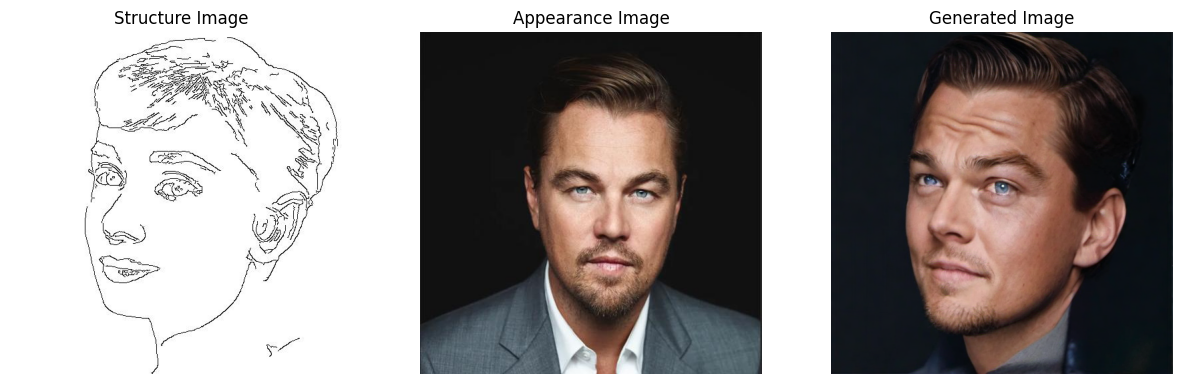

In [15]:
"""
prompt="A face of Leonardo DiCaprio",
structure_prompt="A line sketch of a woman",
appearance_prompt="A photo of Leonardo DiCaprio",
"""

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(structure_image)
axs[0].set_title('Structure Image')
axs[0].axis('off')

axs[1].imshow(appearance_image)
axs[1].set_title('Appearance Image')
axs[1].axis('off')

axs[2].imshow(result[0])
axs[2].set_title('Generated Image')
axs[2].axis('off')

plt.show()